In [1]:
import hydra
from audio_diffusion_pytorch import AudioDiffusionModel
import torch
from main import utils
import numpy as np
import torchaudio
from IPython.display import Audio

hydra.initialize(config_path="..", job_name="test_app")
from omegaconf import OmegaConf


from IPython.display import Audio

# @markdown Both models are equal in size and trained on a variety of music. The 718k version tends to generate piano sounds more often than generic music, where 720k tends to generate orchestra songs more often.
# version = "1136_720k" #@param ["1136_718k", "1136_720k"]
# model = torch.hub.load_state_dict_from_url(
#    f'https://huggingface.co/archinetai/audio-diffusion-pytorch/resolve/main/audio_{version}.pt', map_location='cuda')

#with open("../data/audio_1136_700k.pt", "rb") as f:
#    model.load_state_dict(torch.load(f))

/tmp/ipykernel_3254824/3447540878.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="..", job_name="test_app")


In [52]:
cfg = hydra.compose(config_name="config", overrides=["exp=base_slakh_1"])
#print(OmegaConf.to_yaml(cfg))
utils.extras(cfg)

model_1 = hydra.utils.instantiate(cfg.model, _convert_="partial")
model_2 = hydra.utils.instantiate(cfg.model, _convert_="partial")

ckpt1 = torch.load('../logs/ckpts/drums_slakh/epoch=506-valid_loss=0.043.ckpt')
model_1.load_state_dict(ckpt1['state_dict'])
#del ckpt1

#ckpt2 = torch.load('../logs/ckpts/guitar_slakh/epoch=987-valid_loss=0.008.ckpt')
model_2.load_state_dict(ckpt1['state_dict'])
#del ckpt2

<All keys matched successfully>

In [18]:
# Generate Samples
from audio_diffusion_pytorch import KarrasSchedule, AEulerSampler
from IPython.display import Audio
import math

sampling_rate = 22050

# @markdown Generation length in seconds (will be rounded to be a power of 2 of sample_rate*length)
length = 10 #@param {type: "slider", min: 1, max: 87, step: 1}
length_samples = 2**math.ceil(math.log2(length * sampling_rate))

# @markdown Number of samples to generate
num_samples = 1 #@param {type: "slider", min: 1, max: 16, step: 1}

# @markdown Number of diffusion steps (higher tends to be better but takes longer to generate)
num_steps = 100 #@param {type: "slider", min: 1, max: 200, step: 1}

In [9]:
# with torch.no_grad():
#     samples = model.sample(
#         noise=torch.randn((num_samples, 2, 2 ** length_samples), device='cuda'),
#         num_steps=num_steps,
#         sigma_schedule=KarrasSchedule(
#             sigma_min=1e-4,
#             sigma_max=10.0,
#             rho=7.0
#         ),
#         sampler=AEulerSampler(),
#     )
#
# # Log audio samples
# for i, sample in enumerate(samples):
#     display(Audio(sample.cpu(), rate = sampling_rate))

In [19]:
s1, sr1 = torchaudio.load('../data/drums_22050/validation/validation/Track01501.wav')
s2, sr2 = torchaudio.load('../data/guitar_22050/validation/validation/Track01501.wav')
assert sr1 == sampling_rate
assert sr2 == sampling_rate
# np.load("../data/guitar_22050/source2_48K.npy")

# display(Audio(s1, rate = sampling_rate))
# display(Audio(s2, rate = sampling_rate))

# np.save("source1_48K", samples[0].cpu())
# np.save("source2_48K", samples[2].cpu())

s1 = s1.reshape(1, 1, -1)
s2 = s2.reshape(1, 1, -1)
m = s1+s2

start_sample = 34 * sampling_rate
m = m[:, :, start_sample:start_sample + length_samples]

display(Audio(m.reshape(1,-1), rate = sampling_rate))

In [57]:
from typing import List, Optional

import torch
from torch import Tensor

from audio_diffusion_pytorch.diffusion import AEulerSampler, Diffusion, KarrasSchedule, Sampler, Schedule
from audio_diffusion_pytorch.model import AudioDiffusionModel
from audio_diffusion_pytorch.utils import default, exists


class DiffusionSeparator:
    def __init__(
        self,
        diffusions: List[Diffusion],
        *,
        samplers: List[Sampler],
        sigma_schedules: List[Schedule],
        num_steps: Optional[int] = None,
        eta: int = 0.0005
    ):
        super().__init__()
        self.denoise_fns = [diffusion.denoise_fn for diffusion in diffusions]
        self.samplers = samplers
        self.sigma_schedules = sigma_schedules
        self.num_steps = num_steps
        self.eta = eta

    def forward(self, m: Tensor, noises: List[Tensor], num_steps: Optional[int] = None, **kwargs) -> List[Tensor]:
        device = noises[0].device
        num_steps = default(num_steps, self.num_steps)  # type: ignore
        assert exists(num_steps), "Parameter `num_steps` must be provided"
        
        # Compute sigmas using schedule
        sigmas_list = [sigma_schedule(num_steps, device) for sigma_schedule in self.sigma_schedules]
        
        # Append additional kwargs to denoise function (used e.g. for conditional unet)
        fns = [lambda *a, **ka: denoise_fn(*a, **{**ka, **kwargs}) for denoise_fn in self.denoise_fns]  # noqa
        
        # Separation procedure
        xs = [sigmas[0] * noise for sigmas, noise in zip(sigmas_list, noises)]
        
        @torch.no_grad()
        def perform_sample_step(xs:list, step:int):
            for j, x in enumerate(xs):
                    yield self.samplers[j].step(
                        x, 
                        fn=fns[j], 
                        sigma=sigmas_list[j][step], 
                        sigma_next=sigmas_list[j][step + 1])
        
        # Denoise to sample
        for i in range(num_steps - 1):
            
            # update with respect to the prior
            xs = list(perform_sample_step(xs, i))
            xs = [x.detach() for x in xs]
            
            # compute likelihood function
            # first perturb m with forward noise (works only if sigma scheduler is always the same)
            m_i = m # + torch.randn_like(m) * sigmas_list[0][i]
            #m_i = m[0:1,0:1]
            for x in xs:
                x.requires_grad = True
            
            sum_x = torch.stack(xs).sum(dim=0)
            likelihood = torch.mean(torch.norm(m_i - sum_x, dim=[1, 2]))
            if i%10 == 0: print(likelihood.item())
            likelihood.backward()
            
            for xi, x in enumerate(xs):
                xs[xi] = x - self.eta * x.grad 
                xs[xi].grad = None
        
        xs = [x.clamp(-1.0, 1.0) for x in xs]
        return xs


def separate(
    model1,
    model2,
    mixture, 
    device: torch.device = torch.device("cuda"), 
    num_steps:int = 100,
):
    
    batch, in_channels = 1, 1
    samples = mixture.shape[-1]

    m = torch.tensor(mixture).to(device)
    models = [model1.model, model2.model]
    
    for model in models:
        model.to(device)
        
    diffusion_separator = DiffusionSeparator(
        [model.diffusion for model in models],
        samplers=[AEulerSampler(), AEulerSampler()],
        sigma_schedules=[
            KarrasSchedule(sigma_min=1e-4, sigma_max=10.0, rho=7.0),
            KarrasSchedule(sigma_min=1e-4, sigma_max=10.0, rho=7.0),
        ],
        num_steps=num_steps,
    )
    noises = [torch.randn_like(m).to(device), torch.randn_like(m).to(device)]
    return diffusion_separator.forward(m, noises)
y1, y2 = separate(model_1, model_2, m)

6822.673828125
3726.795166015625
1928.162841796875
934.1450805664062
419.9723205566406
171.34974670410156
66.14302825927734
33.67403030395508
28.88384437561035
28.620487213134766


In [33]:
y1.shape
m.shape

torch.Size([1, 1, 262144])

In [39]:
display(Audio(m.detach().cpu().view(1,-1), rate = sampling_rate))

In [58]:
display(Audio(y1.detach().cpu().view(1,-1), rate = sampling_rate))
display(Audio(y2.detach().cpu().view(1,-1), rate = sampling_rate))
display(Audio((y1+y2).detach().cpu().view(1,-1), rate = sampling_rate))

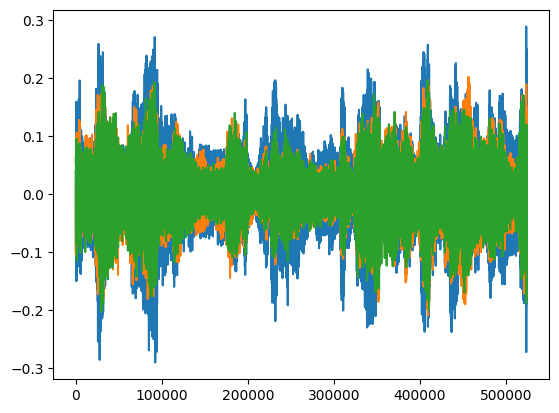

tensor(1.0064, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)


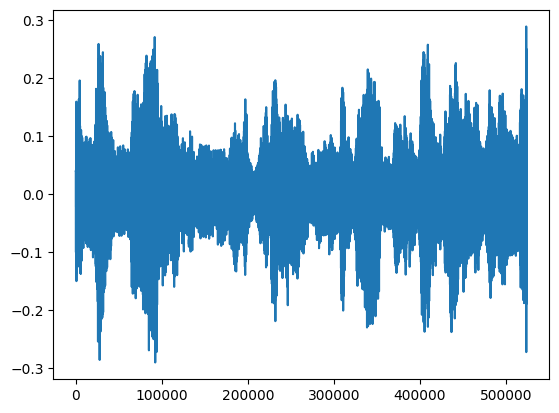

In [12]:
import matplotlib.pyplot as plt

#display(Audio(torch.from_numpy(m).sum(dim=1), rate = sampling_rate))
plt.plot(torch.tensor(m).mean(1).detach().cpu().view(-1))
plt.plot((y1).mean(1).detach().cpu().view(-1))
plt.plot((y2).mean(1).detach().cpu().view(-1))

plt.show()

m=torch.tensor(m).cuda()
print((y1+y2 - m).norm())

sum_x = torch.stack([y1,y2]).sum(dim=0)
likelihood = torch.mean(torch.norm(m - sum_x, dim=[1, 2]))
print(likelihood)

plt.plot(m.mean(dim=1).detach().cpu().view(-1))
plt.show()